In [87]:
import numpy as np
import matplotlib as mpl
#import sympy as sym
from numba import njit
from scipy.signal import find_peaks
from matplotlib  import pyplot as plt
from matplotlib import cm
import time as timer
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from numpy import linalg as LA
import matplotlib
##matplotlib.rcParams['lines.linewidth'] = 2.0
##matplotlib.rcParams['lines.markeredgewidth'] = 0.5
##matplotlib.rcParams['lines.markersize'] = 4
matplotlib.rcParams['font.size'] = 15

In [ ]:
#set parameter
gamma=10
b=8/3
r=28
delta_t=0.001

In [ ]:
##@njit
def dxdt(x,y,z): #A
  return gamma*(y-x)

def dydt(x,y,z): #B
  return r*x-y-x*z

def dzdt(x,y,z): #C
  return x*y-b*z

In [ ]:
#2nd derivertive

##@njit
def d2xdt2(x,y,z):
  return gamma*(dydt(x,y,z)-dxdt(x,y,z))

def d2ydt2(x,y,z):
  A=dxdt(x,y,z)
  B=dydt(x,y,z)
  C=dzdt(x,y,z)
  return r*A-B-x*C-z*A

def d2zdt2(x,y,z):
  A=dxdt(x,y,z)
  B=dydt(x,y,z)
  C=dzdt(x,y,z)

  return x*B+y*A-b*C

In [ ]:
#Sympretic Euler
###@njit
def SE(x,y,z,u,v,w):
  #second deivativs
  ddxdtt=d2xdt2(x,y,z)
  ddydtt=d2ydt2(x,y,z)
  ddzdtt=d2zdt2(x,y,z)

  unew=u+ddxdtt*delta_t
  vnew=v+ddydtt*delta_t
  wnew=w+ddzdtt*delta_t

  xnew=x+unew*delta_t
  ynew=y+vnew*delta_t
  znew=w+wnew*delta_t

  return (xnew,ynew,znew), (unew,vnew,wnew)

In [ ]:
#Verlet Scheme
###@njit
def Verlet(x,y,z,u,v,w):
  ddxdtt=d2xdt2(x,y,z)
  ddydtt=d2ydt2(x,y,z)
  ddzdtt=d2zdt2(x,y,z)

  #x-u
  u12=u+ddxdtt*delta_t/2
  xnew=x+u12*delta_t
  #y-v
  v12=v+ddydtt*delta_t/2
  ynew=y+v12*delta_t
  #z-w
  w12=w+ddzdtt*delta_t/2
  znew=z+w12*delta_t

  unew=u12+d2xdt2(xnew,ynew,znew)*delta_t/2
  vnew=v12+d2ydt2(xnew,ynew,znew)*delta_t/2
  wnew=w12+d2zdt2(xnew,ynew,znew)*delta_t/2

  return (xnew,ynew,znew),(unew,vnew,wnew)


In [ ]:
#RK4
###@njit
def RK4(x,y,z):
  un=np.array([x,y,z])
  u1=un
  k1=np.array([dxdt(x,y,z),dydt(x,y,z),dzdt(x,y,z)])
  u2=un+k1*delta_t/2
  k2=np.array([dxdt(u2[0],u2[1],u2[2]),dydt(u2[0],u2[1],u2[2]),dzdt(u2[0],u2[1],u2[2])])
  u3=un+k2*delta_t/2
  k3=np.array([dxdt(u3[0],u3[1],u3[2]),dydt(u3[0],u3[1],u3[2]),dzdt(u3[0],u3[1],u3[2])])
  u4=un+k3*delta_t
  k4=np.array([dxdt(u4[0],u4[1],u4[2]),dydt(u4[0],u4[1],u4[2]),dzdt(u4[0],u4[1],u4[2])])

  return un+(k1+2*k2+2*k3+k4)*delta_t/6

In [ ]:
#Backward Differentiation Formulas

def BDF(x,y,z,x_1,y_1,z_1):
  xnew=dxdt(x,y,z)*2*delta_t/3+(4*x-x_1)/3
  ynew=dydt(x,y,z)*2*delta_t/3+(4*y-y_1)/3
  znew=dzdt(x,y,z)*2*delta_t/3+(4*z-z_1)/3

  return (xnew,ynew,znew)

In [ ]:
#RK4 main code

x0=0
y0=1
z0=0

u0=dxdt(x0,y0,z0)
v0=dydt(x0,y0,z0)
w0=dzdt(x0,y0,z0)

location_RK=[]
timestep=[]
eigen=[]

xold=x0
yold=y0
zold=z0
uold=u0
vold=v0
wold=w0

iter=0
while (iter < 100000):

  J=np.array([[-10, 10,0],[28-zold,-1,-xold],[yold,xold,-8/3]])
  if iter%1000==0:
    eigenvalues, eigenvectors = LA.eig(J)
    timestep.append(iter)
    #eigen.append(np.max(eigenvalues.real))
    eigen.append(eigenvalues.real)
    #print(np.max(eigenvalues.real))

  location_RK.append((xold,yold,zold))

  xnew,ynew,znew=RK4(xold,yold,zold)

  xold=xnew
  yold=ynew
  zold=znew
  #uold=unew
  #vold=vnew
  #wold=wnew

  iter=iter+1

In [ ]:
joey=np.array(eigen)

In [ ]:
print(eigen)

[array([ -2.66666667,  11.82772345, -22.82772345]), array([-13.69999114,   0.01666224,   0.01666224]), array([-14.56867046,   0.45100189,   0.45100189]), array([-12.87825811,  -0.39420428,  -0.39420428]), array([-14.63074493,   0.48203913,   0.48203913]), array([-13.884861  ,   0.10909716,   0.10909716]), array([-13.13948946,  -0.2635886 ,  -0.2635886 ]), array([-15.20044302,   0.76688818,   0.76688818]), array([-12.31692729,  -0.67486969,  -0.67486969]), array([-15.11064817,   0.72199075,   0.72199075]), array([-13.94244098,   0.13788716,   0.13788716]), array([-13.26805913,  -0.19930377,  -0.19930377]), array([-15.70647264,   1.01990298,   1.01990298]), array([-11.13902447,  -1.2638211 ,  -1.2638211 ]), array([-16.8511688 ,   1.59225107,   1.59225107]), array([-10.28544543,  -1.69061062,  -1.69061062]), array([-16.44901754,   5.1607614 ,  -2.37841053]), array([-18.98968614,   2.66150974,   2.66150974]), array([-16.86571384,   1.59952358,   1.59952358]), array([-13.70681477,   1.41716

Text(0.5, 0, 'timestep')

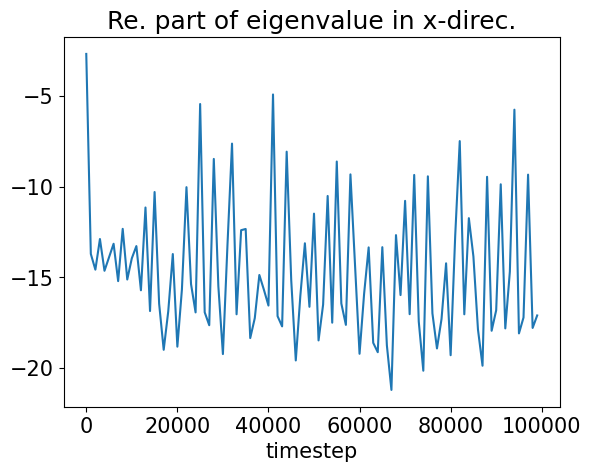

In [88]:
plt.plot(timestep, joey[:,0])
plt.title('Re. part of eigenvalue in x-direc.')
plt.xlabel('timestep')

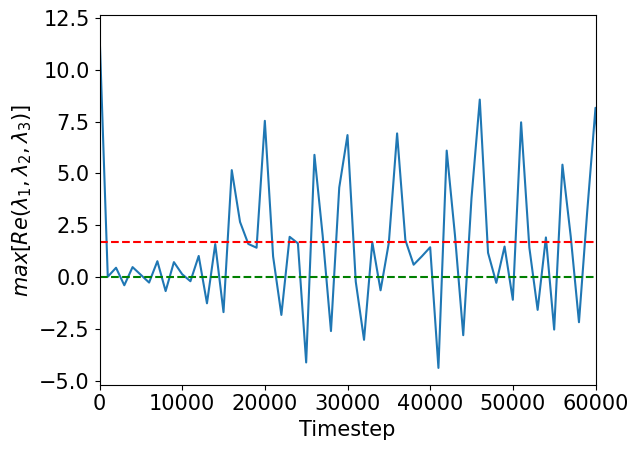

In [91]:
plt.plot(timestep,np.max(joey,axis=1))
plt.hlines(0,0,60000,linestyles='dashed', colors='g')
plt.xlim(0,60000)
plt.xlabel('Timestep')
plt.ylabel(r'$max[Re(\lambda_1,\lambda_2,\lambda_3)]$')
plt.hlines(np.mean(np.max(joey,axis=1)),0,60000,linestyles='dashed', colors='r')

In [ ]:
ndlocation_RK=np.array(location_RK)

Text(0.5, 0, 'Z')

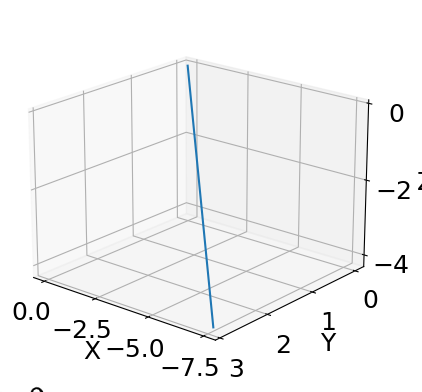

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

value=np.linspace(0,1,len(ndlocation_RK))/len(ndlocation_RK)
ax.plot(ndlocation_RK[:,0], ndlocation_RK[:,1], ndlocation_RK[:,2])
ax.view_init(elev=20, azim=130, roll=0)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
#plt.colorbar(ticks=np.arange(0, 10000, 50))

<ipython-input-37-d6af3e45302d>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_RK)), cmap='Wistia'), label='timestep')


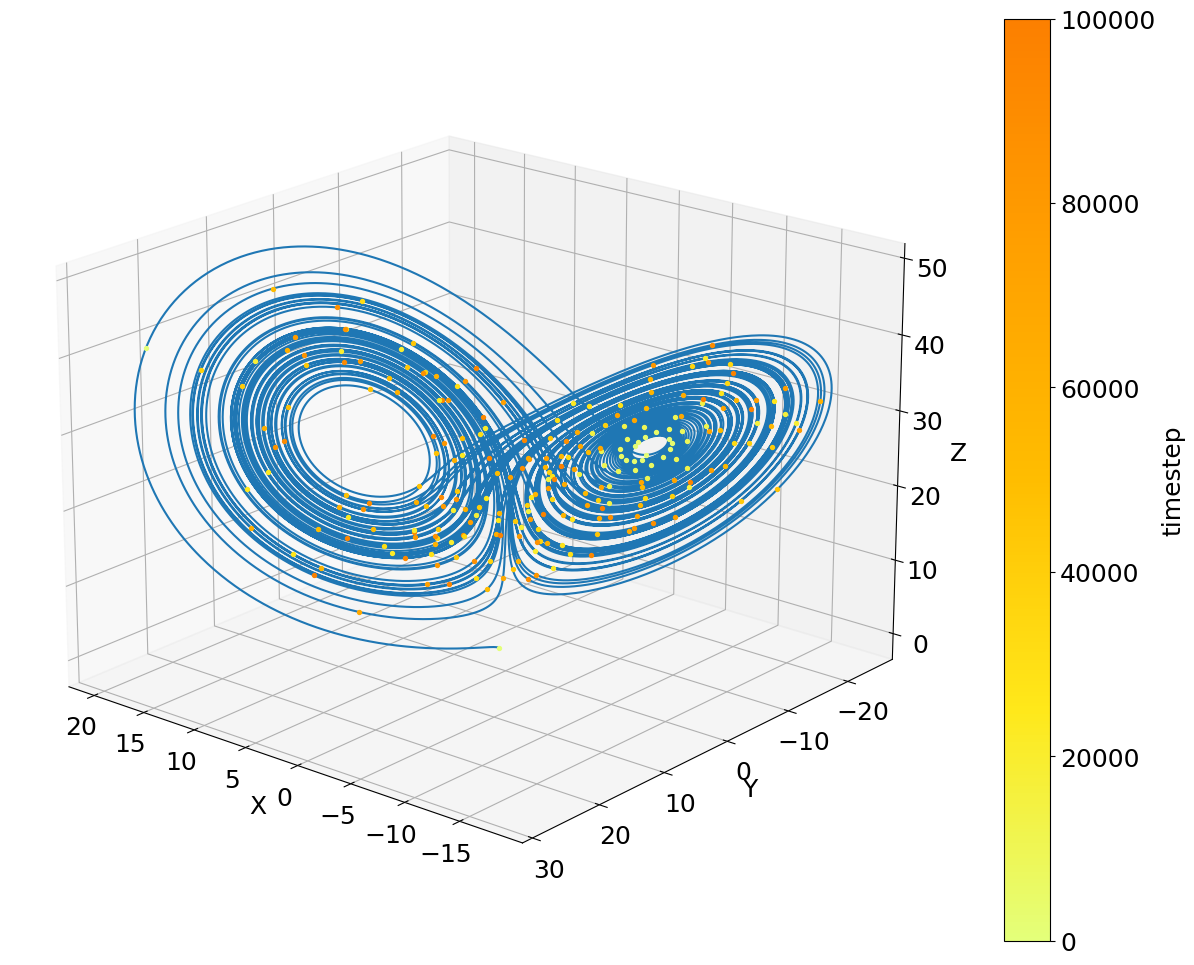

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(location_RK)))


ax = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
ax.plot(ndlocation_RK[:,0], ndlocation_RK[:,1], ndlocation_RK[:,2])

for i in range(0,len(ndlocation_RK),400):
  ax.scatter(ndlocation_RK[i,0], ndlocation_RK[i,1], ndlocation_RK[i,2],color=colors[i],s=8)

ax.view_init(elev=20, azim=130, roll=0)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_RK)), cmap='Wistia'), label='timestep')
#plt.scatter(np.sqrt(b*(r-1)),np.sqrt(b*(r-1)),r-1,color='black')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()

Text(0, 0.5, 'y')

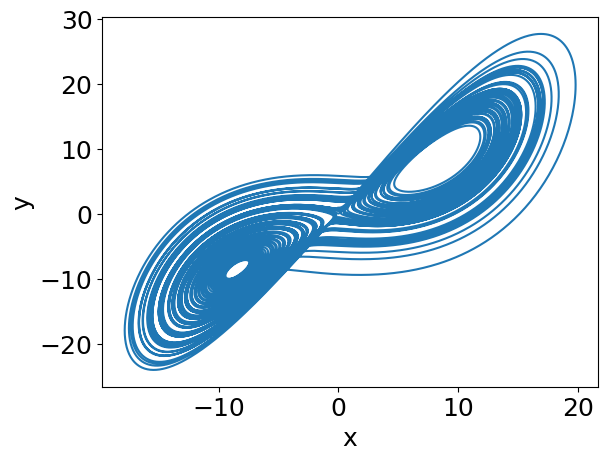

In [ ]:
plt.plot(ndlocation_RK[:,0], ndlocation_RK[:,1])

plt.xlabel("x")
plt.ylabel("y")
#plt.scatter(0,1,c="black")

Text(0, 0.5, 'z')

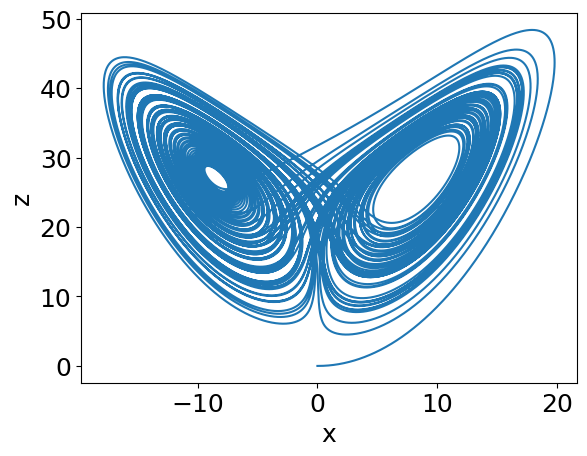

In [ ]:
plt.plot(ndlocation_RK[:,0], ndlocation_RK[:,2])
plt.xlabel("x")
plt.ylabel("z")

In [ ]:
#BDF main code

x0=0
y0=1
z0=0

u0=dxdt(x0,y0,z0)
v0=dydt(x0,y0,z0)
w0=dzdt(x0,y0,z0)

location_BDF=[]
velocity_BDF=[]

xold=x0
yold=y0
zold=z0
x_1=x0
y_1=y0
z_1=z0

iter=0
while (iter < 100000):
  location_BDF.append((xold,yold,zold))

  xnew,ynew,znew=BDF(xold,yold,zold,x_1,y_1,z_1)

  x_1=xold
  y_1=yold
  z_1=zold

  xold=xnew
  yold=ynew
  zold=znew

  iter=iter+1

In [ ]:
ndlocation_BDF=np.array(location_BDF)

Text(0.5, 0, 'Z')

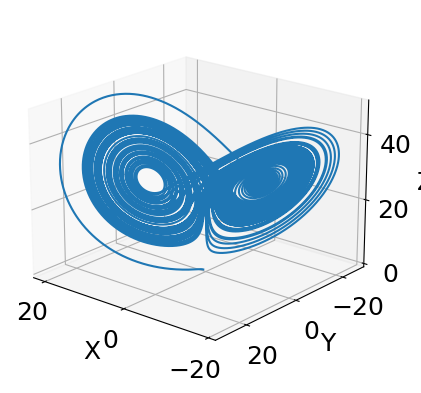

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

value=np.linspace(0,1,len(ndlocation_BDF))/len(ndlocation_BDF)
ax.plot(ndlocation_BDF[:,0], ndlocation_BDF[:,1], ndlocation_BDF[:,2])
ax.view_init(elev=20, azim=130, roll=0)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<ipython-input-16-caba0c14aa29>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_BDF)), cmap='Wistia'), label='timestep')


Text(0.5, 0, 'Z')

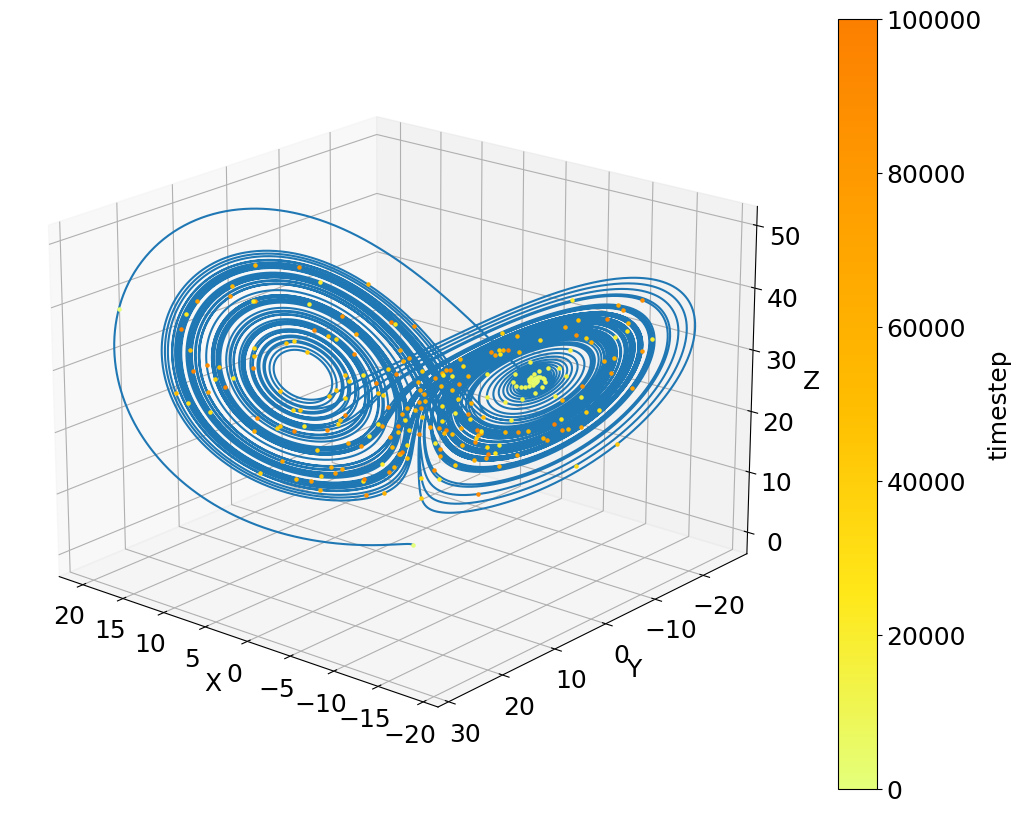

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(location_BDF)))


ax = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
ax.plot(ndlocation_BDF[:,0], ndlocation_BDF[:,1], ndlocation_BDF[:,2])

for i in range(0,len(ndlocation_RK),400):
  ax.scatter(ndlocation_BDF[i,0], ndlocation_BDF[i,1], ndlocation_BDF[i,2],color=colors[i],s=5)

ax.view_init(elev=20, azim=130, roll=0)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_BDF)), cmap='Wistia'), label='timestep')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [ ]:
#Verlet Scheme
x0=0
y0=1
z0=0

u0=dxdt(x0,y0,z0)
v0=dydt(x0,y0,z0)
w0=dzdt(x0,y0,z0)

location_VS=[]
velocity_VS=[]

xold=x0
yold=y0
zold=z0
uold=u0
vold=v0
wold=w0

iter=0
while (iter < 100000):
  location_VS.append((xold,yold,zold))
  velocity_VS.append((uold,vold,wold))

  xnew,ynew,znew=Verlet(xold,yold,zold,uold,vold,wold)[0]
  unew,vnew,wnew=Verlet(xold,yold,zold,uold,vold,wold)[1]

  xold=xnew
  yold=ynew
  zold=znew
  uold=unew
  vold=vnew
  wold=wnew

  iter=iter+1

In [ ]:
ndlocation_VS=np.array(location_VS)

In [ ]:
#print(ndlocation_VS[1300:1500])

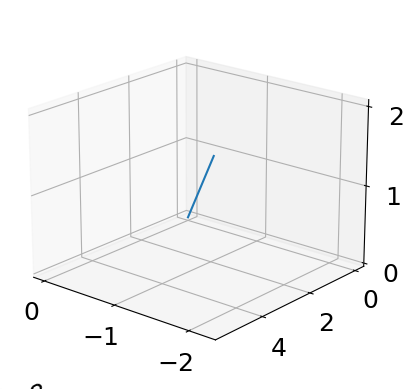

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

value=np.linspace(0,1,len(ndlocation_VS))/len(ndlocation_VS)
ax.plot(ndlocation_VS[:,0], ndlocation_VS[:,1], ndlocation_VS[:,2])
ax.view_init(elev=20, azim=130, roll=0)
#plt.colorbar(ticks=np.arange(0, 10000, 50))

In [ ]:
#Symplectic Euler

x0=0
y0=1
z0=0

u0=dxdt(x0,y0,z0)
v0=dydt(x0,y0,z0)
w0=dzdt(x0,y0,z0)

location=[]
velocity=[]

xold=x0
yold=y0
zold=z0
uold=u0
vold=v0
wold=w0

iter=0
while (iter < 100000):
  location.append((xold,yold,zold))
  velocity.append((uold,vold,wold))

  xnew,ynew,znew=SE(xold,yold,zold,uold,vold,wold)[0]
  unew,vnew,wnew=SE(xold,yold,zold,uold,vold,wold)[1]

  xold=xnew
  yold=ynew
  zold=znew
  uold=unew
  vold=vnew
  wold=wnew

  iter=iter+1

In [ ]:
ndlocation=np.array(location)

In [ ]:
#Predictor-Corrector
#main code
x0=0
y0=1
z0=0

u0=dxdt(x0,y0,z0)
v0=dydt(x0,y0,z0)
w0=dzdt(x0,y0,z0)

location_PC=[]
velocity_PC=[]

xold=x0
yold=y0
zold=z0
uold=u0
vold=v0
wold=w0

iter=0
while (iter < 100000):
  location_PC.append((xold,yold,zold))
  x12=xold+dxdt(xold,yold,zold)*delta_t/2
  y12=yold+dydt(xold,yold,zold)*delta_t/2
  z12=zold+dzdt(xold,yold,zold)*delta_t/2

  xnew=xold+dxdt(x12,y12,z12)*delta_t
  ynew=yold+dydt(x12,y12,z12)*delta_t
  znew=zold+dzdt(x12,y12,z12)*delta_t

  xold=xnew
  yold=ynew
  zold=znew

  iter=iter+1

In [ ]:
ndlocation_PC=np.array(location_PC)

In [ ]:
#print(location_PC)
print(len(ndlocation_PC))

100000


Text(0.5, 0, 'Z')

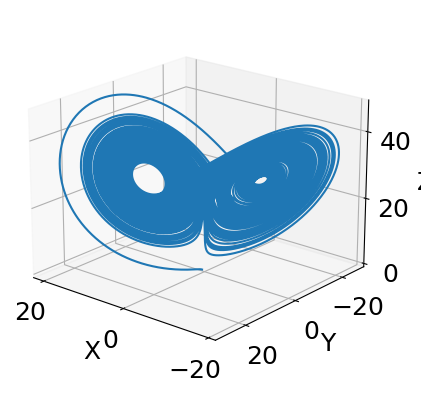

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

value=np.linspace(0,1,len(ndlocation_PC))/len(ndlocation_PC)
ax.plot(ndlocation_PC[:,0], ndlocation_PC[:,1], ndlocation_PC[:,2])

ax.view_init(elev=20, azim=130, roll=0)
#plt.colorbar(ticks=np.arange(0, 10000, 50))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<ipython-input-27-9358901b9aa1>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_PC)), cmap='Wistia'), label='timestep')


Text(0.5, 0, 'Z')

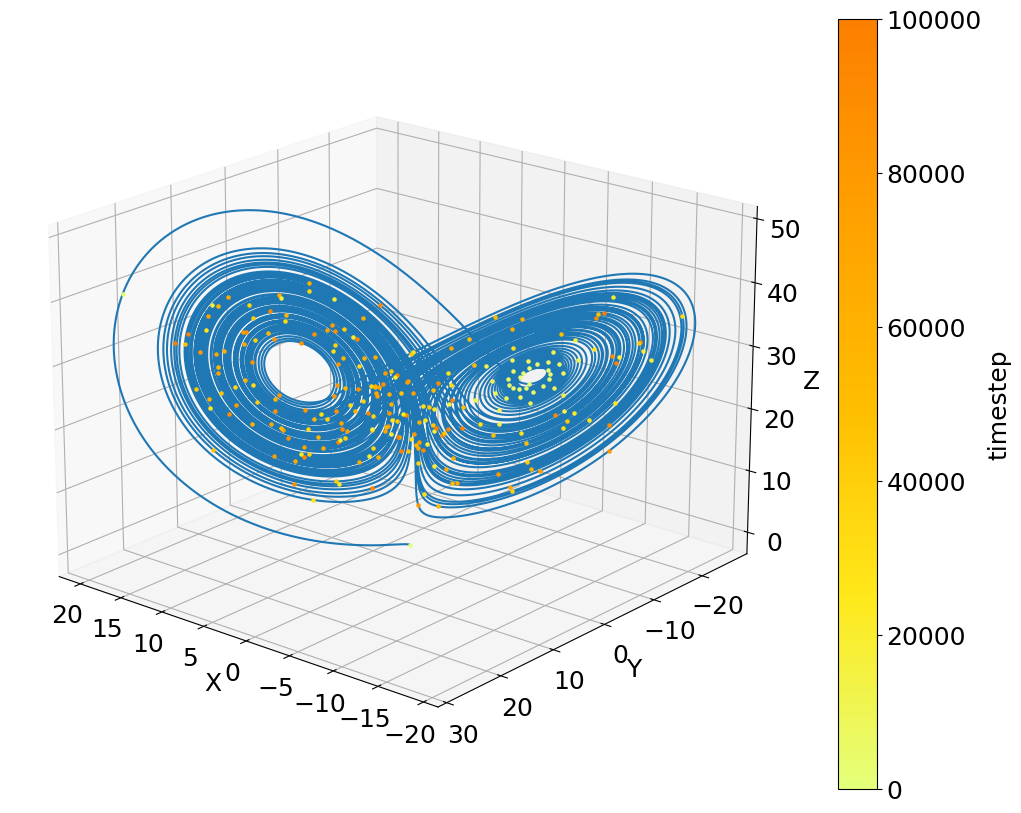

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(location_PC)))


ax = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
ax.plot(ndlocation_PC[:,0], ndlocation_PC[:,1], ndlocation_PC[:,2])

for i in range(0,len(ndlocation_PC),400):
  ax.scatter(ndlocation_PC[i,0], ndlocation_PC[i,1], ndlocation_PC[i,2],color=colors[i],s=5)

ax.view_init(elev=20, azim=130, roll=0)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,len(location_PC)), cmap='Wistia'), label='timestep')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

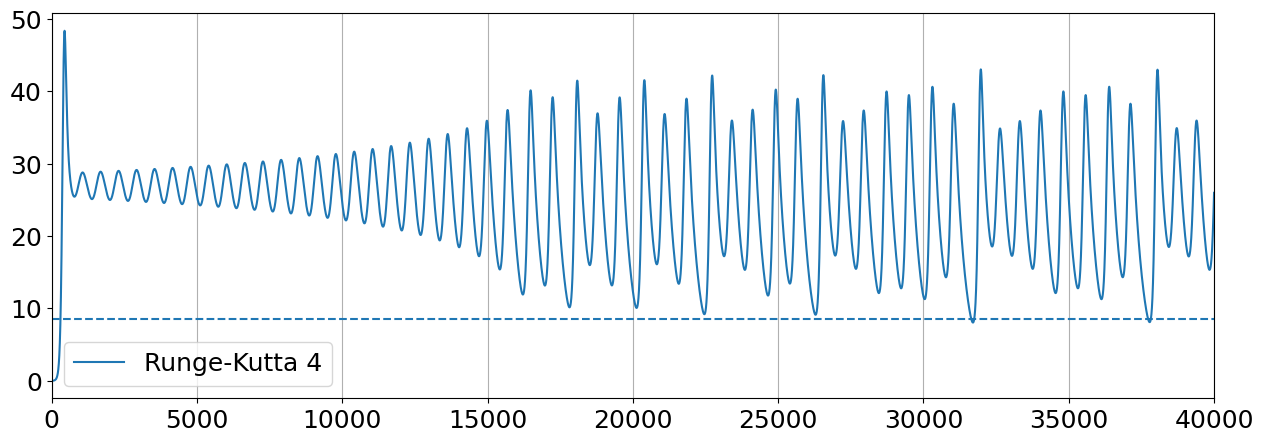

In [ ]:
plt.figure(figsize=(15,5))
#plt.plot(ndlocation_PC[0:40000,2],label='Predictor-Corrector')
plt.plot(ndlocation_RK[0:40000,2],label='Runge-Kutta 4',)
#plt.plot(ndlocation_BDF[0:40000,2],label='BDF')
plt.hlines(np.sqrt(b*(r-1)),0,40000,linestyles='dashed')
plt.xlim(0,40000)
plt.grid(axis='x')
plt.legend()

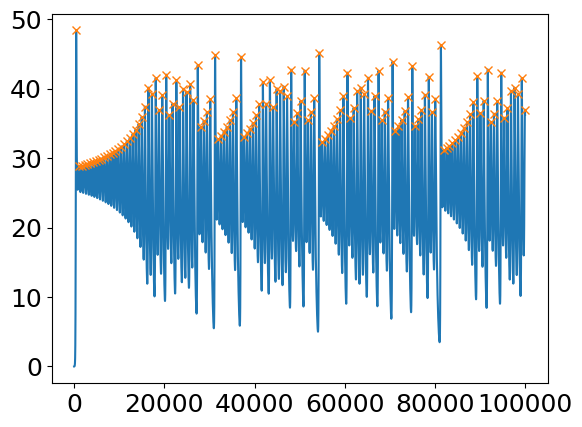

In [ ]:
peaksPC, _ = find_peaks(ndlocation_PC[0::,2])#, distance=10,plateau_size=1
#print(peaks)
plt.plot(ndlocation_PC[0::,2])
plt.plot(peaksPC, ndlocation_PC[peaksPC,2], "x")


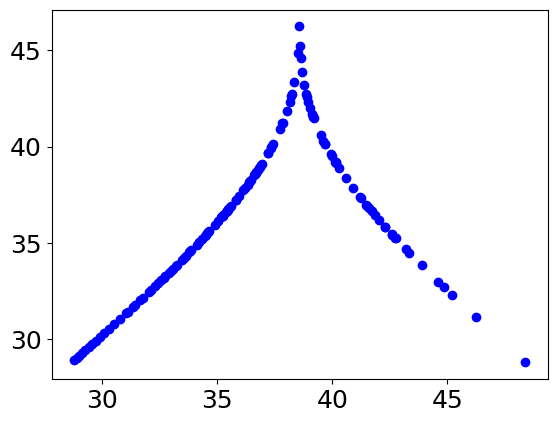

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(location_PC)))
for i in range(len(peaksPC)-1):
  #print(i)
  #print(peaks[i])
  plt.scatter(ndlocation_PC[peaksPC[i],2], ndlocation_PC[peaksPC[i+1],2],color="blue")

(30.0, 47.0)

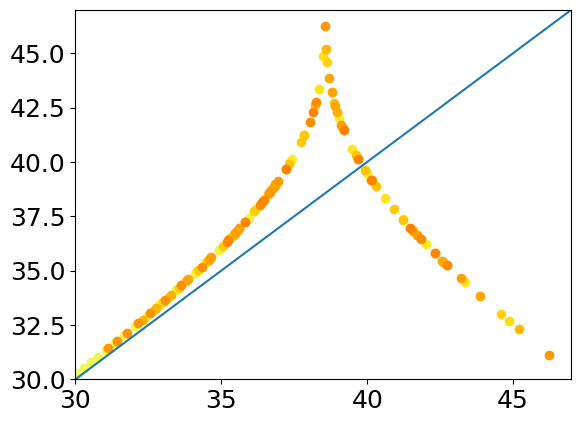

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(peaksPC)))
for i in range(len(peaksPC)-1):
  #print(i)
  #print(peaks[i])
  plt.scatter(ndlocation_PC[peaksPC[i],2], ndlocation_PC[peaksPC[i+1],2],color=colors[i])

plt.plot(np.linspace(0,47),np.linspace(0,47))
plt.xlim(30,47)
plt.ylim(30,47)

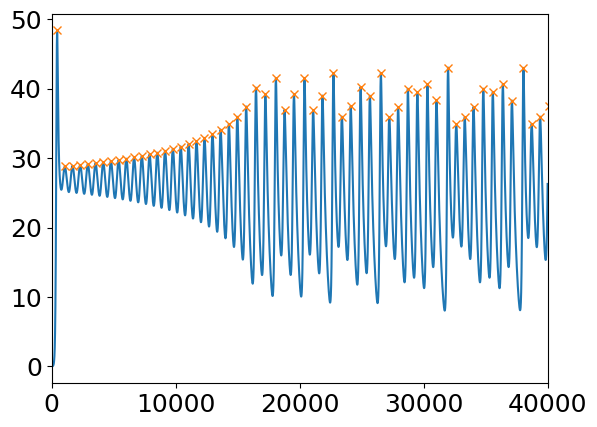

In [ ]:
peaksRK, _ = find_peaks(ndlocation_RK[0::,2])#, distance=10,plateau_size=1
#print(peaks)
plt.plot(ndlocation_RK[0:100000,2])
plt.xlim(0,40000)
plt.plot(peaksRK, ndlocation_RK[peaksRK,2], "x")

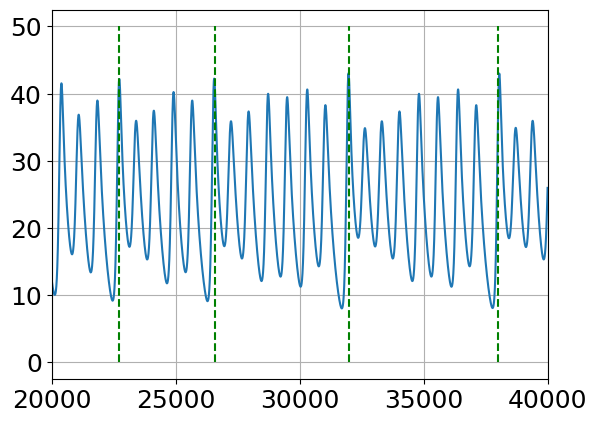

In [ ]:
plt.plot(ndlocation_RK[0:40000,2])
plt.vlines(22700,0,50,linestyles='dashed',colors='g')
plt.vlines(26600,0,50,linestyles='dashed',colors='g')
plt.vlines(32000,0,50,linestyles='dashed',colors='g')
plt.vlines(38000,0,50,linestyles='dashed',colors='g')
plt.xlim(20000,40000)
plt.grid()

Text(0, 0.5, '$z_{max,n+1}$')

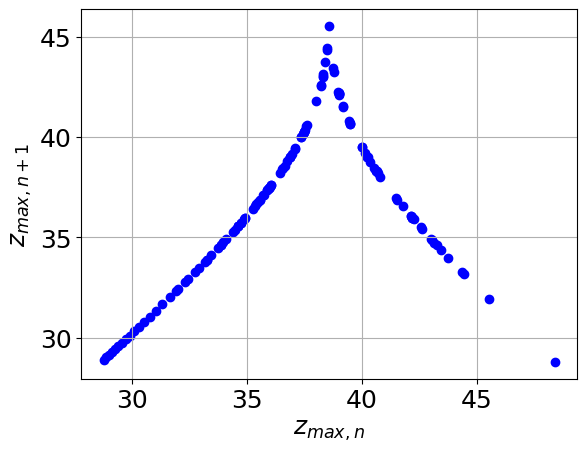

In [ ]:
colors = cm.Wistia(np.linspace(0, 1, len(peaksPC)))
for i in range(len(peaksRK)-1):
  #print(i)
  #print(peaks[i])
  plt.scatter(ndlocation_RK[peaksRK[i],2], ndlocation_RK[peaksRK[i+1],2],color="blue")

plt.grid()
#plt.plot(np.linspace(29,45),np.linspace(29,45),color='r')
plt.xlabel(r'$z_{max,n}$')
plt.ylabel(r'$z_{max,n+1}$')
#plt.xlim(29,48)
#plt.ylim(29,48)

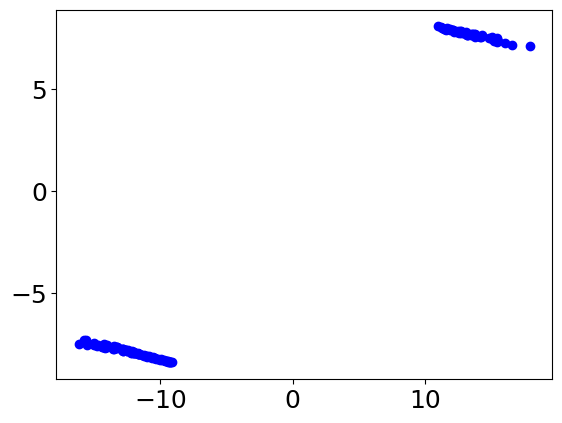

In [ ]:
for i in range(len(peaksRK)):
  plt.scatter(ndlocation_RK[peaksRK[i],0], ndlocation_RK[peaksRK[i],1],color="blue")

ValueError: x and y must have same first dimension, but have shapes (139,) and (137,)

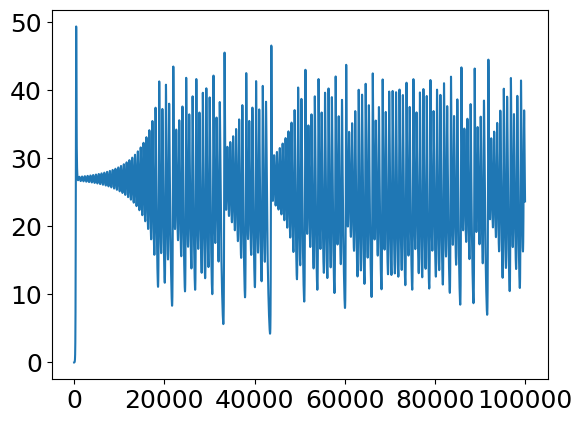

In [ ]:
peaksBDF, _ = find_peaks(ndlocation_BDF[0::,2])#, distance=10,plateau_size=1
#print(peaks)
plt.plot(ndlocation_BDF[0::,2])
plt.plot(peaksBDF, ndlocation_BDF[peaksRK,2], "x")

In [ ]:
for i in range(len(peaksBDF)-1):
  plt.scatter(ndlocation_BDF[peaksBDF[i],2], ndlocation_BDF[peaksBDF[i+1],2],color="blue")

In [ ]:
for i in range(len(peaksRK)-1):
  plt.scatter(ndlocation_RK[peaksRK[i],2], ndlocation_RK[peaksRK[i+1],2],color="blue")

for i in range(len(peaksPC)-1):
  plt.scatter(ndlocation_PC[peaksPC[i],2], ndlocation_PC[peaksPC[i+1],2],color="red")

for i in range(len(peaksBDF)-1):
  plt.scatter(ndlocation_BDF[peaksBDF[i],2], ndlocation_BDF[peaksBDF[i+1],2],color="g")

plt.grid()
plt.xlabel(r'$z_{max,n}$')
plt.ylabel(r'$z_{max,n+1}$')
